In [1]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os
import json
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 14
import seaborn as sns
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet,MobileNetV2
from tensorflow.keras.applications.mobilenet import preprocess_input
start = dt.datetime.now()

In [2]:
DP_DIR = 'E:\\DLDATA\\all'
INPUT_DIR = 'E:\\DLDATA\\all\\'

BASE_SIZE = 256
NCSVS = 100
NCATS = 340
np.random.seed(seed=1987)
tf.set_random_seed(seed=1987)

def f2cat(filename: str) -> str:
    return filename.split('.')[0]

def list_all_categories():
    files = os.listdir(os.path.join(INPUT_DIR, 'train_simplified'))
    return sorted([f2cat(f) for f in files], key=str.lower)

In [3]:
def apk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    if len(predicted) > k:
        predicted = predicted[:k]
    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    if not actual:
        return 0.0
    return score / min(len(actual), k)
def mapk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

def preds2catids(predictions):
    return pd.DataFrame(np.argsort(-predictions, axis=1)[:, :3], columns=['a', 'b', 'c'])

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [4]:

# EPOCHS = 16
# batchsize = 256
# size = 64
# STEPS = 2000#680 mobinenetV1 之前是step2000batchsize未知记得ctrl+Z

STEPS = 680
EPOCHS = 16
size = 64
batchsize = 512

In [5]:
model = MobileNetV2(input_shape=(size, size, 1), alpha=1., weights=None, classes=NCATS)
model.compile(optimizer=Adam(lr=0.002), loss='categorical_crossentropy',
              metrics=[categorical_crossentropy, categorical_accuracy, top_3_accuracy])
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 65, 65, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 32, 32, 32)   288         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 32, 32, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

In [6]:
def draw_cv2(raw_strokes, size=256, lw=6, time_color=True):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = 255 - min(t, 10) * 13 if time_color else 255
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size))
    else:
        return img

def image_generator_xd(size, batchsize, ks, lw=6, time_color=True):
    while True:
        for k in np.random.permutation(ks):
            filename = os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(k))
            for df in pd.read_csv(filename, chunksize=batchsize):
                df['drawing'] = df['drawing'].apply(json.loads)
                x = np.zeros((len(df), size, size, 1))
                for i, raw_strokes in enumerate(df.drawing.values):
                    x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw,
                                             time_color=time_color)
                x = preprocess_input(x).astype(np.float32)
                y = keras.utils.to_categorical(df.y, num_classes=NCATS)
                yield x, y

def df_to_image_array_xd(df, size, lw=6, time_color=True):
    df['drawing'] = df['drawing'].apply(json.loads)
    x = np.zeros((len(df), size, size, 1))
    for i, raw_strokes in enumerate(df.drawing.values):
        x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw, time_color=time_color)
    x = preprocess_input(x).astype(np.float32)
    return x

In [7]:
valid_df = pd.read_csv(os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(NCSVS - 1)), nrows=34000)
x_valid = df_to_image_array_xd(valid_df, size)
y_valid = keras.utils.to_categorical(valid_df.y, num_classes=NCATS)
print(x_valid.shape, y_valid.shape)
print('Validation array memory {:.2f} GB'.format(x_valid.nbytes / 1024.**3 ))

(34000, 64, 64, 1) (34000, 340)
Validation array memory 0.52 GB


In [8]:
train_datagen = image_generator_xd(size=size, batchsize=batchsize, ks=range(NCSVS - 1))

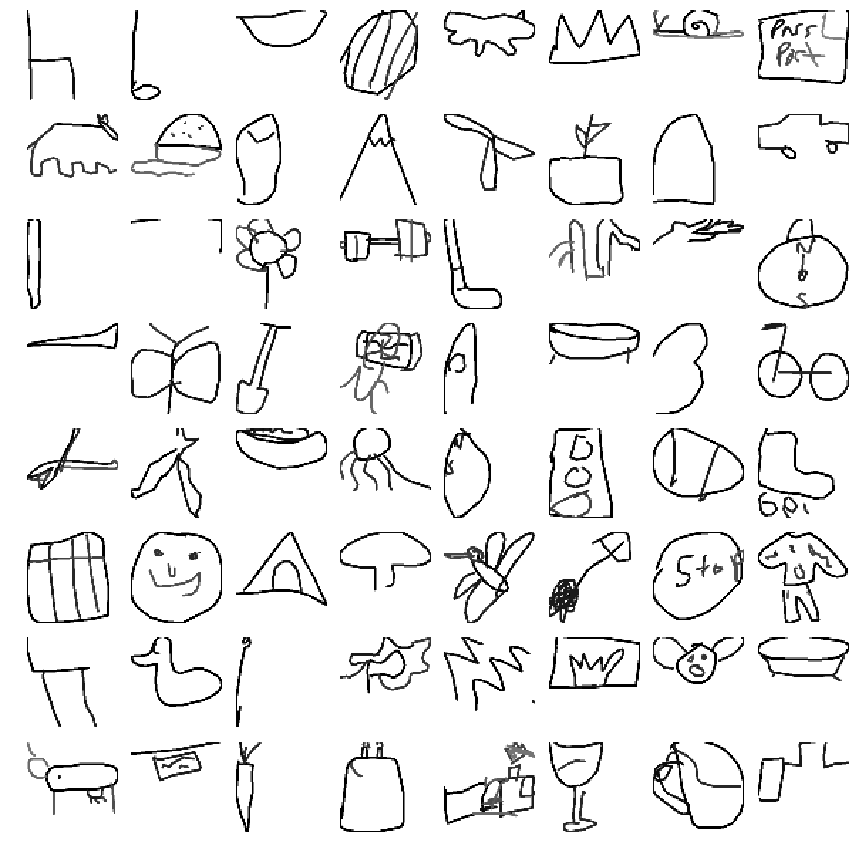

In [9]:
x, y = next(train_datagen)
n = 8
fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True, figsize=(12, 12))
for i in range(n**2):
    ax = axs[i // n, i % n]
    (-x[i]+1)/2
    ax.imshow((-x[i, :, :, 0] + 1)/2, cmap=plt.cm.gray)
    ax.axis('off')
plt.tight_layout()
fig.savefig('MobileNetV2.png', dpi=300)
plt.show();

In [10]:
x, y = next(train_datagen)

In [11]:
callbacks = [
    ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.75, patience=3, min_delta=0.001,
                          mode='max', min_lr=1e-5, verbose=1),
   
    ModelCheckpoint('MobileNetV2checkpoint.h5', monitor='val_top_3_accuracy', mode='max', save_best_only=True,
                    save_weights_only=True),
]
hists = []
hist = model.fit_generator(
    train_datagen, steps_per_epoch=STEPS, epochs=70, verbose=1,
    validation_data=(x_valid, y_valid),
    callbacks = callbacks
)
hists.append(hist)

Epoch 1/70
680/680 [==============================] - 291s 427ms/step - loss: 3.1495 - categorical_crossentropy: 3.1495 - categorical_accuracy: 0.3062 - top_3_accuracy: 0.4860 - val_loss: 7.4441 - val_categorical_crossentropy: 7.4441 - val_categorical_accuracy: 0.0025 - val_top_3_accuracy: 0.0081
Epoch 2/70
680/680 [==============================] - 263s 387ms/step - loss: 1.9315 - categorical_crossentropy: 1.9315 - categorical_accuracy: 0.5277 - top_3_accuracy: 0.7368 - val_loss: 7.7402 - val_categorical_crossentropy: 7.7402 - val_categorical_accuracy: 0.0030 - val_top_3_accuracy: 0.0090
Epoch 3/70
680/680 [==============================] - 265s 389ms/step - loss: 1.6774 - categorical_crossentropy: 1.6774 - categorical_accuracy: 0.5840 - top_3_accuracy: 0.7845 - val_loss: 7.6533 - val_categorical_crossentropy: 7.6533 - val_categorical_accuracy: 0.0030 - val_top_3_accuracy: 0.0086
Epoch 4/70
680/680 [==============================] - 266s 391ms/step - loss: 1.5452 - categorical_crossen

Epoch 27/70
680/680 [==============================] - 265s 390ms/step - loss: 0.9828 - categorical_crossentropy: 0.9828 - categorical_accuracy: 0.7476 - top_3_accuracy: 0.8953 - val_loss: 2.0032 - val_categorical_crossentropy: 2.0032 - val_categorical_accuracy: 0.5151 - val_top_3_accuracy: 0.7238
Epoch 28/70
680/680 [==============================] - 264s 388ms/step - loss: 0.9862 - categorical_crossentropy: 0.9862 - categorical_accuracy: 0.7474 - top_3_accuracy: 0.8950 - val_loss: 1.0918 - val_categorical_crossentropy: 1.0918 - val_categorical_accuracy: 0.7250 - val_top_3_accuracy: 0.8816
Epoch 29/70
680/680 [==============================] - 265s 389ms/step - loss: 0.9787 - categorical_crossentropy: 0.9787 - categorical_accuracy: 0.7493 - top_3_accuracy: 0.8957 - val_loss: 1.0472 - val_categorical_crossentropy: 1.0472 - val_categorical_accuracy: 0.7326 - val_top_3_accuracy: 0.8875
Epoch 30/70
680/680 [==============================] - 265s 389ms/step - loss: 0.9789 - categorical_cro

Epoch 51/70
680/680 [==============================] - 264s 389ms/step - loss: 0.8856 - categorical_crossentropy: 0.8856 - categorical_accuracy: 0.7729 - top_3_accuracy: 0.9088 - val_loss: 0.8984 - val_categorical_crossentropy: 0.8984 - val_categorical_accuracy: 0.7703 - val_top_3_accuracy: 0.9070
Epoch 52/70
680/680 [==============================] - 264s 388ms/step - loss: 0.8841 - categorical_crossentropy: 0.8841 - categorical_accuracy: 0.7722 - top_3_accuracy: 0.9085 - val_loss: 0.8913 - val_categorical_crossentropy: 0.8913 - val_categorical_accuracy: 0.7748 - val_top_3_accuracy: 0.9074
Epoch 53/70
680/680 [==============================] - 266s 392ms/step - loss: 0.8821 - categorical_crossentropy: 0.8821 - categorical_accuracy: 0.7739 - top_3_accuracy: 0.9091 - val_loss: 0.8919 - val_categorical_crossentropy: 0.8919 - val_categorical_accuracy: 0.7725 - val_top_3_accuracy: 0.9078
Epoch 54/70
679/680 [============================>.] - ETA: 0s - loss: 0.8885 - categorical_crossentrop

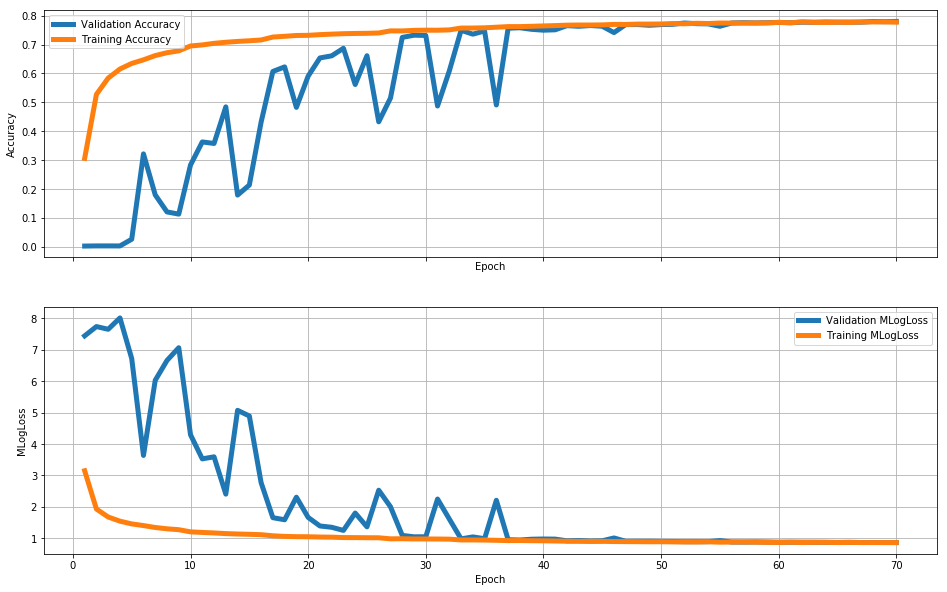

In [12]:
hist_df = pd.concat([pd.DataFrame(hist.history) for hist in hists], sort=True)
hist_df.index = np.arange(1, len(hist_df)+1)
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
axs[0].plot(hist_df.val_categorical_accuracy, lw=5, label='Validation Accuracy')
axs[0].plot(hist_df.categorical_accuracy, lw=5, label='Training Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].grid()
axs[0].legend(loc=0)
axs[1].plot(hist_df.val_categorical_crossentropy, lw=5, label='Validation MLogLoss')
axs[1].plot(hist_df.categorical_crossentropy, lw=5, label='Training MLogLoss')
axs[1].set_ylabel('MLogLoss')
axs[1].set_xlabel('Epoch')
axs[1].grid()
axs[1].legend(loc=0)
fig.savefig('fig_MobileNetV2.png', dpi=300)
plt.show();

In [13]:
hist_df.to_csv("hist_MobileNetV2.csv")

In [14]:
valid_predictions = model.predict(x_valid, batch_size=128, verbose=1)
map3 = mapk(valid_df[['y']].values, preds2catids(valid_predictions).values)
print('Map3: {:.3f}'.format(map3))

34000/34000 [==============================] - 9s 253us/step
Map3: 0.838


In [15]:
model.save_weights("MobileNetV2.h5")

In [16]:
test = pd.read_csv(os.path.join(INPUT_DIR, 'test_simplified.csv'))
test.head()
x_test = df_to_image_array_xd(test, size)
print(test.shape, x_test.shape)
print('Test array memory {:.2f} GB'.format(x_test.nbytes / 1024.**3 ))

,key_id,countrycode,drawing
0,9000003627287624,DE,"[[[17, 18, 20, 25, 137, 174, 242, 249, 251, 25..."
1,9000010688666847,UA,"[[[174, 145, 106, 38, 11, 4, 4, 15, 29, 78, 16..."
2,9000023642890129,BG,"[[[0, 12, 14, 17, 16, 24, 55, 57, 60, 79, 82, ..."
3,9000038588854897,US,"[[[0, 9, 23, 40, 54, 60, 81, 105, 123, 167, 20..."
4,9000052667981386,AR,"[[[87, 82, 71, 63, 66, 92, 96, 95], [220, 218,..."


(112199, 3) (112199, 64, 64, 1)
Test array memory 1.71 GB


In [17]:
test_predictions = model.predict(x_test, batch_size=128, verbose=1)

top3 = preds2catids(test_predictions)
top3.head()
top3.shape

cats = list_all_categories()
id2cat = {k: cat.replace(' ', '_') for k, cat in enumerate(cats)}
top3cats = top3.replace(id2cat)
top3cats.head()
top3cats.shape

112199/112199 [==============================] - 32s 283us/step


,a,b,c
0,234,281,266
1,144,36,226
2,305,62,110
3,187,303,294
4,113,56,84


(112199, 3)

,a,b,c
0,radio,stereo,snorkel
1,hockey_puck,bottlecap,pool
2,The_Great_Wall_of_China,castle,fence
3,mountain,tent,swing_set
4,fireplace,campfire,crown


(112199, 3)

In [18]:


test['word'] = top3cats['a'] + ' ' + top3cats['b'] + ' ' + top3cats['c']
submission = test[['key_id', 'word']]
submission.to_csv('submission_{}MobileNetV2.csv'.format(int(map3 * 10**4)), index=False)
submission.head()
submission.shape



,key_id,word
0,9000003627287624,radio stereo snorkel
1,9000010688666847,hockey_puck bottlecap pool
2,9000023642890129,The_Great_Wall_of_China castle fence
3,9000038588854897,mountain tent swing_set
4,9000052667981386,fireplace campfire crown


(112199, 2)

In [19]:
end = dt.datetime.now()
print('Latest run {}.\nTotal time {}s'.format(end, (end - start).seconds))

Latest run 2019-01-10 05:33:50.219974.
Total time 18684s
